### Importing Libraries

In [3]:
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
import PIL
from PIL import Image,ImageOps
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchmetrics import JaccardIndex
import datasets_segmentation as dataset

%load_ext autoreload
%autoreload 2

### Loading model and dataloaders

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

images_dir = "../../data/unet_shenken_data/"

In [5]:
#Loading Model
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
                       in_channels=1, out_channels=1, init_features=32, pretrained=False)
model = model.to(device)

#Hyperparamaters
num_epochs = 100
val_check = 5
lr = 0.0002
beta1 = 0.5
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(beta1, 0.999))
criterion = nn.BCELoss()
jaccard = JaccardIndex(task = 'binary', num_classes=2)

Using cache found in /home/rmpatil/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


### Dice Coefficient

In [6]:
#Dice Coefficient
def dice_coeff(pred, target):
    smooth = 1.
    pred = torch.where(pred>=0.5, 1, 0)
    iflat = pred.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return 1 - ((2. * intersection + smooth) /
              (iflat.sum() + tflat.sum() + smooth))

### Visualizing model outputs

In [7]:
#Function for visualization
def visualize(data,pred,label):
    batchsize = data.size()[0]
    fig, axs = plt.subplots(batchsize,3,figsize=(10,10))
    for i in range(batchsize):        
        img_plot = data[i].permute(1,2,0).detach().cpu()
        pred_plot = pred[i].permute(1,2,0).detach().cpu()
        label_plot = label[i].permute(1,2,0).detach().cpu()
        
        axs[i,0].imshow(img_plot)
        axs[i,0].set_title('Image')
        
        axs[i,1].imshow(pred_plot,cmap='gray')
        axs[i,1].set_title('Prediction')
        
        axs[i,2].imshow(label_plot,cmap='gray')
        axs[i,2].set_title('Label')
        
    plt.show()

### Validation and Test Loops

In [8]:
#Validation Loop
def validation(model,dataloader):
    losses = []
    model.eval()
    for i, (data, targets) in enumerate(dataloader, 0):
        data = data.to(device)
        targets = targets.to(device)

        pred = model(data)
        loss = criterion(pred,targets)
        losses.append(loss.item())
    return np.mean(losses)

#Test Loop
def test(model_path, dataloader):
    model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
                       in_channels=1, out_channels=1, init_features=32, pretrained=False)
    weights = torch.load(model_path)
    model.load_state_dict(weights)
    model = model.to(device)
    dice_scores = []
    model.eval()
    with torch.no_grad():
        for i, (data, targets) in enumerate(dataloader, 0):
            data = data.to(device)
            targets = targets.type(torch.int8).to(device)

            pred = model(data)
            dice_scores.append(jaccard(pred.cpu(), targets.cpu()))
    return np.mean(dice_scores)

### Training

In [12]:
def train(model, train_dataloader, val_dataloader, model_path):
    best_loss = np.inf

    print(f"Training for model {model_path}")
    # For each epoch
    for epoch in tqdm(range(num_epochs)):
        losses = []

        # For each batch in the dataloader
        for data, targets in train_dataloader:

            data = data.to(device)
            targets = targets.to(device).to(torch.float32)
            optimizer.zero_grad()
            pred = model(data)
            loss = criterion(pred,targets)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        print("[TRAIN] Epoch : %d, Loss : %2.5f" % (epoch, np.mean(losses)))

        if (epoch + 1) % val_check == 0:
            visualize(data[0:3],pred[0:3],targets[0:3])

            cur_loss = validation(model, val_dataloader)
            print("[VALIDATION] Epoch : %d, Loss : %2.5f" % (epoch, cur_loss))
            if cur_loss < best_loss:
                best_loss = cur_loss
                torch.save(model.state_dict(), os.path.join("seg", model_path))  

Training for model model_no_aug_0_train_100.pt


  1%|          | 1/100 [00:32<53:47, 32.60s/it]

[TRAIN] Epoch : 0, Loss : 0.34496


  2%|▏         | 2/100 [01:05<53:33, 32.80s/it]

[TRAIN] Epoch : 1, Loss : 0.28341


  3%|▎         | 3/100 [01:39<53:57, 33.38s/it]

[TRAIN] Epoch : 2, Loss : 0.25911


  4%|▍         | 4/100 [02:26<1:02:15, 38.91s/it]

[TRAIN] Epoch : 3, Loss : 0.24013
[TRAIN] Epoch : 4, Loss : 0.22860


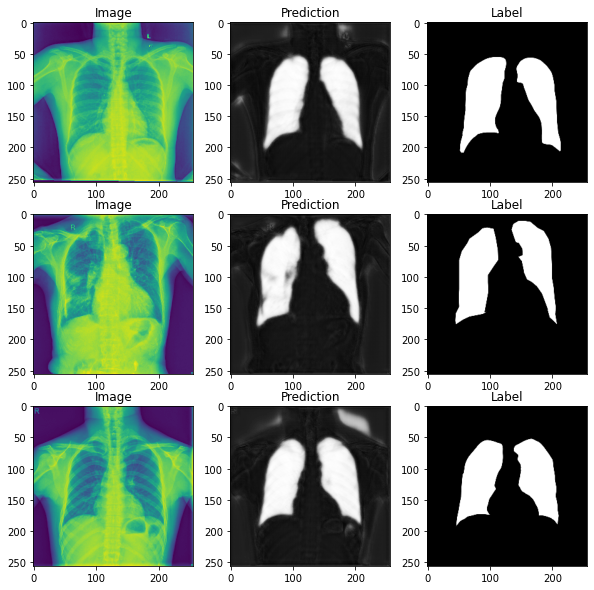

[VALIDATION] Epoch : 4, Loss : 0.24059


  6%|▌         | 6/100 [04:26<1:17:02, 49.17s/it]

[TRAIN] Epoch : 5, Loss : 0.45179


  7%|▋         | 7/100 [05:04<1:10:32, 45.51s/it]

[TRAIN] Epoch : 6, Loss : 0.36661


  8%|▊         | 8/100 [05:38<1:04:26, 42.03s/it]

[TRAIN] Epoch : 7, Loss : 0.34559


  9%|▉         | 9/100 [06:19<1:02:59, 41.53s/it]

[TRAIN] Epoch : 8, Loss : 0.29498
[TRAIN] Epoch : 9, Loss : 0.35877


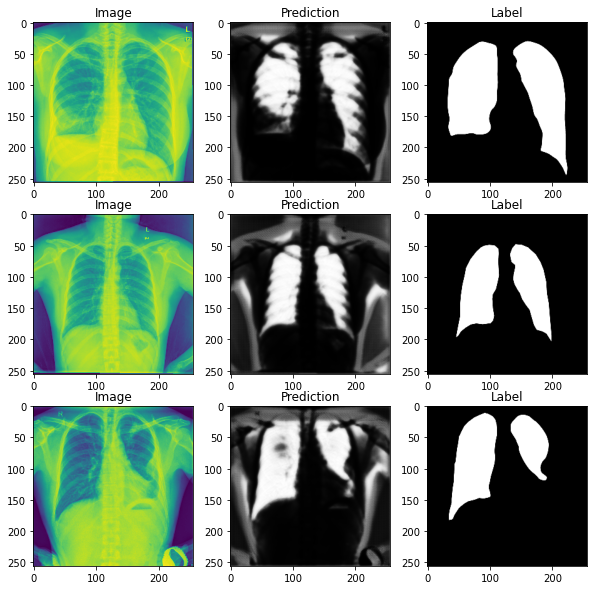

 10%|█         | 10/100 [07:41<1:21:10, 54.11s/it]

[VALIDATION] Epoch : 9, Loss : 0.30451


 11%|█         | 11/100 [08:36<1:20:34, 54.32s/it]

[TRAIN] Epoch : 10, Loss : 0.23492


 12%|█▏        | 12/100 [09:19<1:14:38, 50.89s/it]

[TRAIN] Epoch : 11, Loss : 0.22499


 13%|█▎        | 13/100 [10:00<1:09:31, 47.94s/it]

[TRAIN] Epoch : 12, Loss : 0.15750


 14%|█▍        | 14/100 [10:37<1:04:11, 44.79s/it]

[TRAIN] Epoch : 13, Loss : 0.15810
[TRAIN] Epoch : 14, Loss : 0.13478


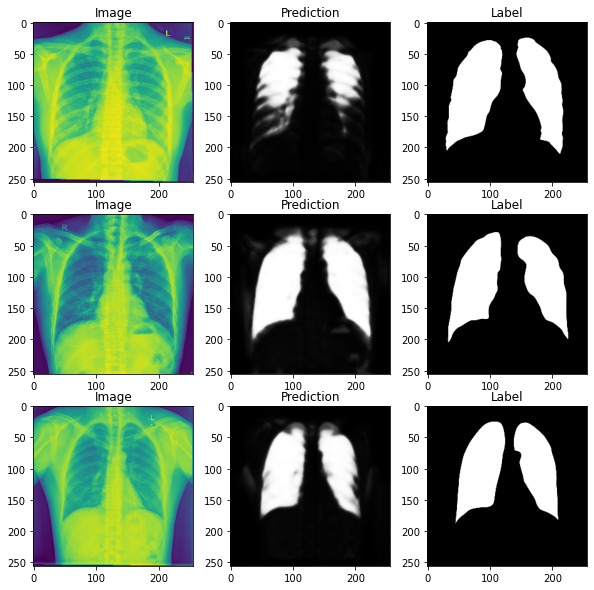

[VALIDATION] Epoch : 14, Loss : 0.13337


 16%|█▌        | 16/100 [12:38<1:10:47, 50.57s/it]

[TRAIN] Epoch : 15, Loss : 0.10627


 17%|█▋        | 17/100 [13:21<1:07:00, 48.44s/it]

[TRAIN] Epoch : 16, Loss : 0.08129


 18%|█▊        | 18/100 [13:54<59:51, 43.80s/it]  

[TRAIN] Epoch : 17, Loss : 0.08142


 19%|█▉        | 19/100 [14:48<1:03:06, 46.75s/it]

[TRAIN] Epoch : 18, Loss : 0.07513
[TRAIN] Epoch : 19, Loss : 0.06255


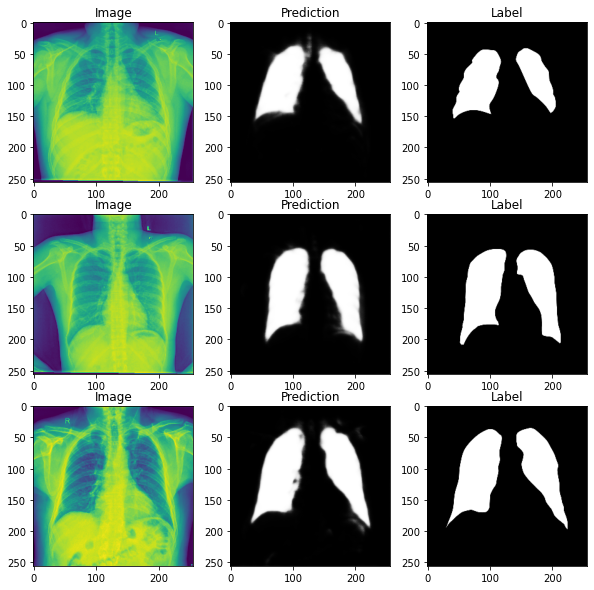

[VALIDATION] Epoch : 19, Loss : 0.09427


 21%|██        | 21/100 [16:56<1:09:58, 53.14s/it]

[TRAIN] Epoch : 20, Loss : 0.31765


 22%|██▏       | 22/100 [17:40<1:05:26, 50.34s/it]

[TRAIN] Epoch : 21, Loss : 0.21116


 23%|██▎       | 23/100 [18:18<1:00:07, 46.84s/it]

[TRAIN] Epoch : 22, Loss : 0.14896


 24%|██▍       | 24/100 [18:57<56:18, 44.46s/it]  

[TRAIN] Epoch : 23, Loss : 0.11816
[TRAIN] Epoch : 24, Loss : 0.20064


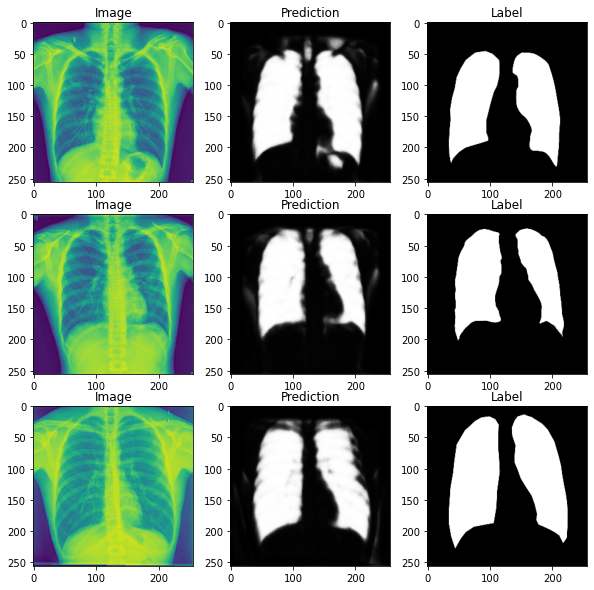

 25%|██▌       | 25/100 [20:19<1:09:27, 55.57s/it]

[VALIDATION] Epoch : 24, Loss : 0.12536


 26%|██▌       | 26/100 [21:10<1:06:53, 54.23s/it]

[TRAIN] Epoch : 25, Loss : 0.12435


 27%|██▋       | 27/100 [21:51<1:01:06, 50.23s/it]

[TRAIN] Epoch : 26, Loss : 0.09575


 28%|██▊       | 28/100 [22:30<56:14, 46.87s/it]  

[TRAIN] Epoch : 27, Loss : 0.07893


 29%|██▉       | 29/100 [23:12<53:39, 45.34s/it]

[TRAIN] Epoch : 28, Loss : 0.06921
[TRAIN] Epoch : 29, Loss : 0.06739


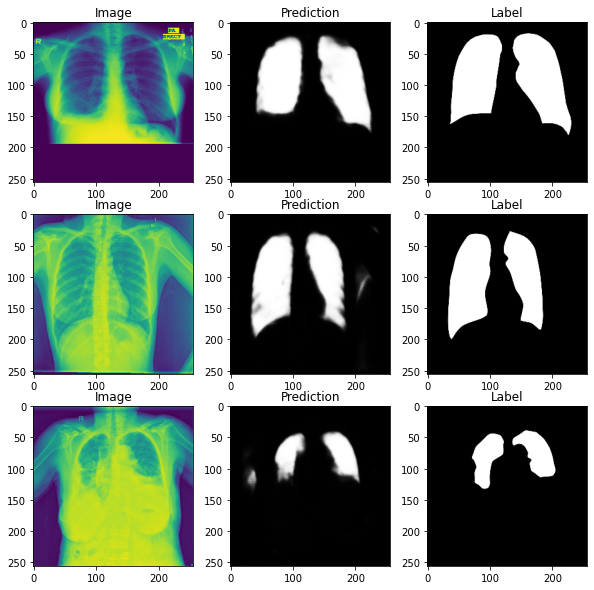

[VALIDATION] Epoch : 29, Loss : 0.06655


 31%|███       | 31/100 [25:14<58:48, 51.14s/it]  

[TRAIN] Epoch : 30, Loss : 0.06020


 32%|███▏      | 32/100 [25:48<51:57, 45.85s/it]

[TRAIN] Epoch : 31, Loss : 0.08780


 33%|███▎      | 33/100 [26:18<46:01, 41.21s/it]

[TRAIN] Epoch : 32, Loss : 0.09372


 34%|███▍      | 34/100 [27:01<45:49, 41.66s/it]

[TRAIN] Epoch : 33, Loss : 0.06538
[TRAIN] Epoch : 34, Loss : 0.05769


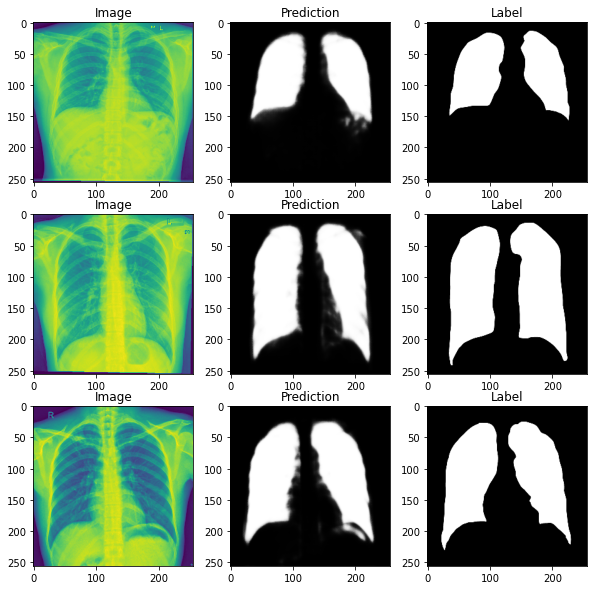

 35%|███▌      | 35/100 [28:14<55:28, 51.21s/it]

[VALIDATION] Epoch : 34, Loss : 0.08461


 36%|███▌      | 36/100 [28:51<49:45, 46.65s/it]

[TRAIN] Epoch : 35, Loss : 0.05974


 37%|███▋      | 37/100 [29:25<45:13, 43.07s/it]

[TRAIN] Epoch : 36, Loss : 0.05198


 38%|███▊      | 38/100 [30:00<41:54, 40.56s/it]

[TRAIN] Epoch : 37, Loss : 0.05447


 39%|███▉      | 39/100 [30:34<39:19, 38.68s/it]

[TRAIN] Epoch : 38, Loss : 0.05024
[TRAIN] Epoch : 39, Loss : 0.05030


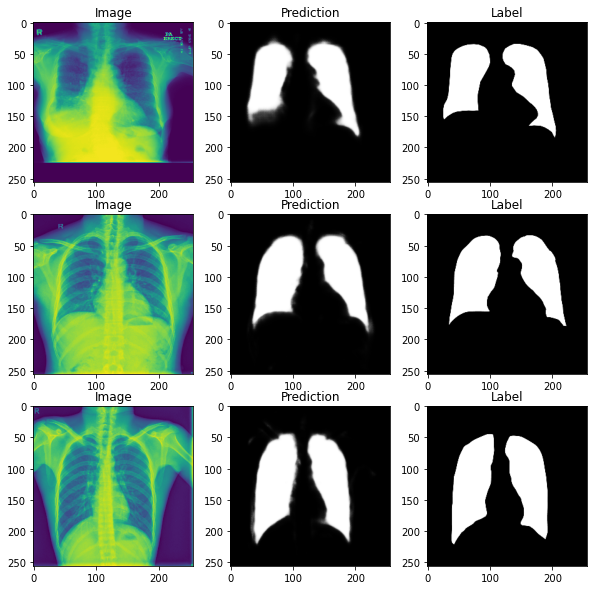

[VALIDATION] Epoch : 39, Loss : 0.06334


 41%|████      | 41/100 [32:29<45:48, 46.59s/it]

[TRAIN] Epoch : 40, Loss : 0.05022


 42%|████▏     | 42/100 [33:05<41:53, 43.34s/it]

[TRAIN] Epoch : 41, Loss : 0.04782


 43%|████▎     | 43/100 [33:39<38:37, 40.65s/it]

[TRAIN] Epoch : 42, Loss : 0.04789


 44%|████▍     | 44/100 [34:11<35:38, 38.19s/it]

[TRAIN] Epoch : 43, Loss : 0.04526
[TRAIN] Epoch : 44, Loss : 0.04916


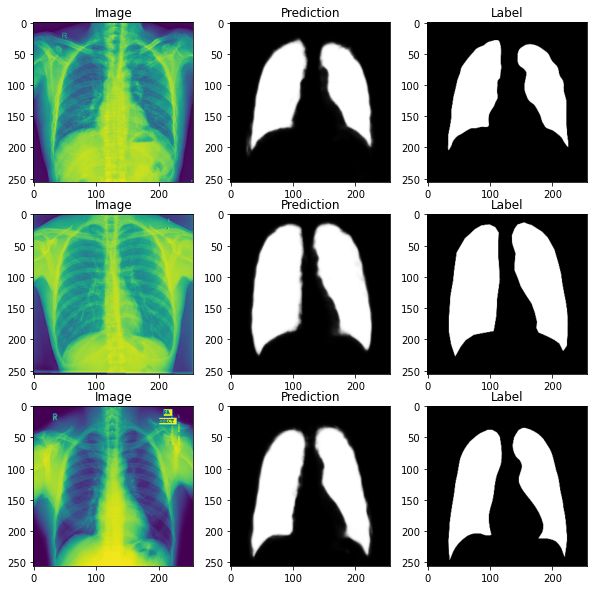

[VALIDATION] Epoch : 44, Loss : 0.05483


 46%|████▌     | 46/100 [36:02<40:27, 44.96s/it]

[TRAIN] Epoch : 45, Loss : 0.04703


 47%|████▋     | 47/100 [36:31<35:39, 40.37s/it]

[TRAIN] Epoch : 46, Loss : 0.04537


 48%|████▊     | 48/100 [37:09<34:20, 39.63s/it]

[TRAIN] Epoch : 47, Loss : 0.04336


 49%|████▉     | 49/100 [37:47<33:07, 38.97s/it]

[TRAIN] Epoch : 48, Loss : 0.04518
[TRAIN] Epoch : 49, Loss : 0.04292


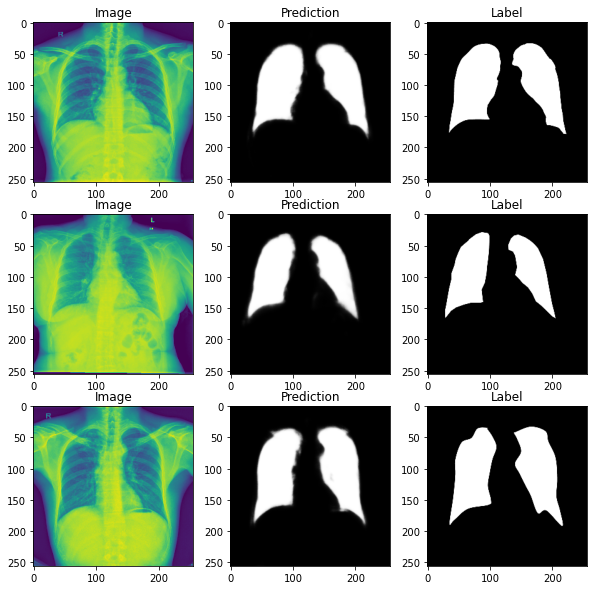

[VALIDATION] Epoch : 49, Loss : 0.05482


 51%|█████     | 51/100 [39:32<36:12, 44.33s/it]

[TRAIN] Epoch : 50, Loss : 0.04266


 52%|█████▏    | 52/100 [40:10<33:47, 42.25s/it]

[TRAIN] Epoch : 51, Loss : 0.05711


 53%|█████▎    | 53/100 [40:43<30:54, 39.45s/it]

[TRAIN] Epoch : 52, Loss : 0.04823


 54%|█████▍    | 54/100 [41:18<29:18, 38.23s/it]

[TRAIN] Epoch : 53, Loss : 0.04886
[TRAIN] Epoch : 54, Loss : 0.04430


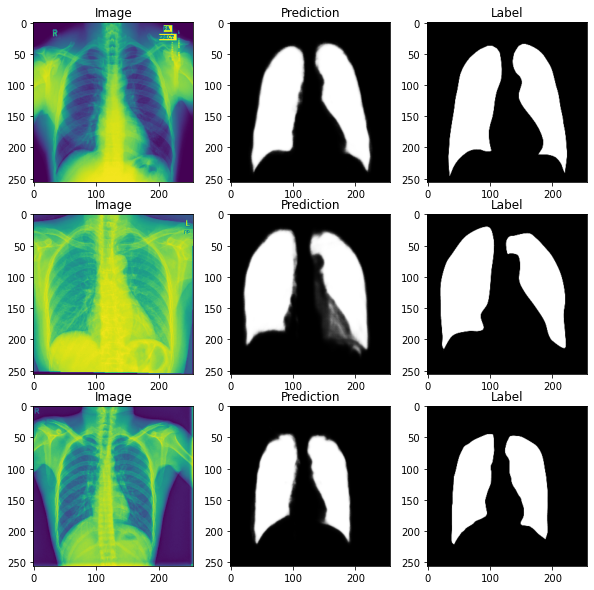

 55%|█████▌    | 55/100 [42:34<37:11, 49.59s/it]

[VALIDATION] Epoch : 54, Loss : 0.05670


 56%|█████▌    | 56/100 [43:09<33:03, 45.09s/it]

[TRAIN] Epoch : 55, Loss : 0.04244


 57%|█████▋    | 57/100 [43:45<30:24, 42.43s/it]

[TRAIN] Epoch : 56, Loss : 0.04135


 58%|█████▊    | 58/100 [44:17<27:29, 39.27s/it]

[TRAIN] Epoch : 57, Loss : 0.04159


 59%|█████▉    | 59/100 [44:53<26:07, 38.23s/it]

[TRAIN] Epoch : 58, Loss : 0.03946
[TRAIN] Epoch : 59, Loss : 0.03841


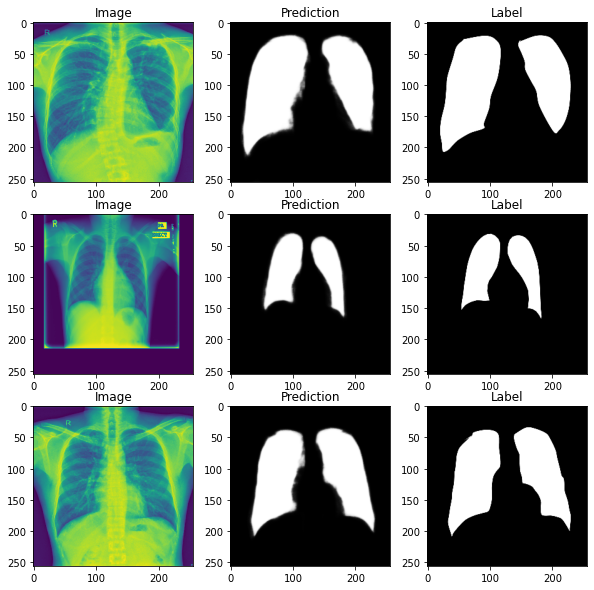

 60%|██████    | 60/100 [46:08<32:53, 49.35s/it]

[VALIDATION] Epoch : 59, Loss : 0.06251


 61%|██████    | 61/100 [46:40<28:39, 44.08s/it]

[TRAIN] Epoch : 60, Loss : 0.03826


 62%|██████▏   | 62/100 [47:21<27:20, 43.16s/it]

[TRAIN] Epoch : 61, Loss : 0.03763


 63%|██████▎   | 63/100 [47:57<25:17, 41.02s/it]

[TRAIN] Epoch : 62, Loss : 0.03696


 64%|██████▍   | 64/100 [48:29<23:07, 38.55s/it]

[TRAIN] Epoch : 63, Loss : 0.03748
[TRAIN] Epoch : 64, Loss : 0.03601


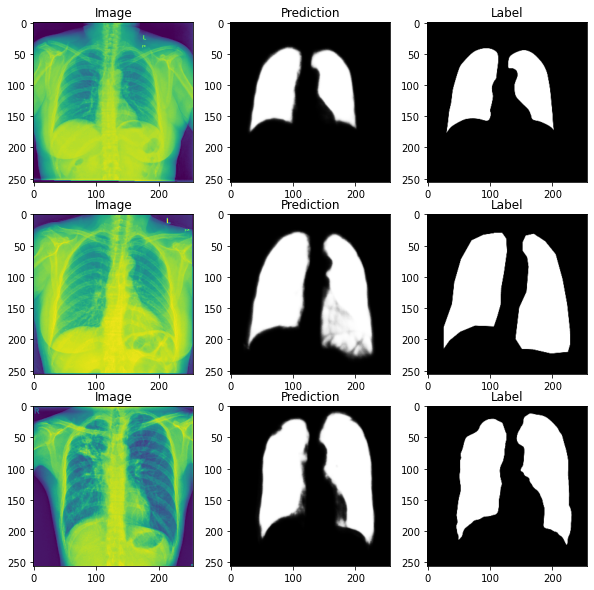

 65%|██████▌   | 65/100 [49:45<28:59, 49.69s/it]

[VALIDATION] Epoch : 64, Loss : 0.06650


 66%|██████▌   | 66/100 [50:21<25:46, 45.47s/it]

[TRAIN] Epoch : 65, Loss : 0.03608


 67%|██████▋   | 67/100 [50:56<23:19, 42.41s/it]

[TRAIN] Epoch : 66, Loss : 0.03577


 68%|██████▊   | 68/100 [51:31<21:29, 40.29s/it]

[TRAIN] Epoch : 67, Loss : 0.03460


 69%|██████▉   | 69/100 [52:02<19:20, 37.43s/it]

[TRAIN] Epoch : 68, Loss : 0.03412
[TRAIN] Epoch : 69, Loss : 0.03372


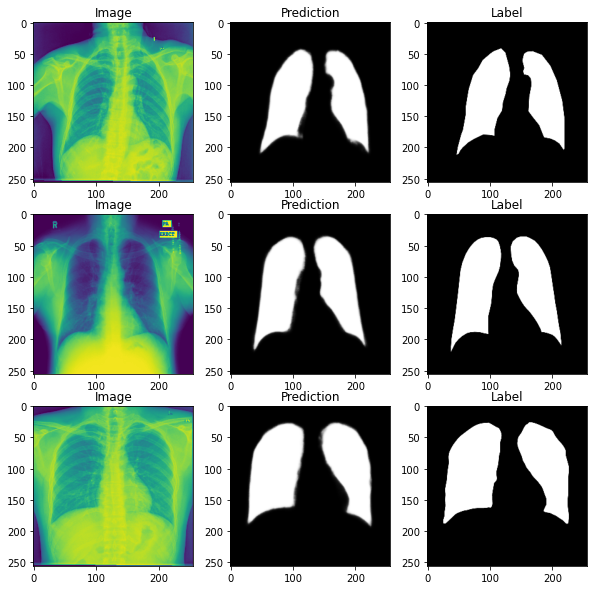

 70%|███████   | 70/100 [53:26<25:41, 51.37s/it]

[VALIDATION] Epoch : 69, Loss : 0.05934


 71%|███████   | 71/100 [54:01<22:28, 46.49s/it]

[TRAIN] Epoch : 70, Loss : 0.03364


 72%|███████▏  | 72/100 [54:34<19:47, 42.41s/it]

[TRAIN] Epoch : 71, Loss : 0.03284


 73%|███████▎  | 73/100 [55:09<18:06, 40.25s/it]

[TRAIN] Epoch : 72, Loss : 0.03214


 74%|███████▍  | 74/100 [55:45<16:50, 38.86s/it]

[TRAIN] Epoch : 73, Loss : 0.05780
[TRAIN] Epoch : 74, Loss : 0.04122


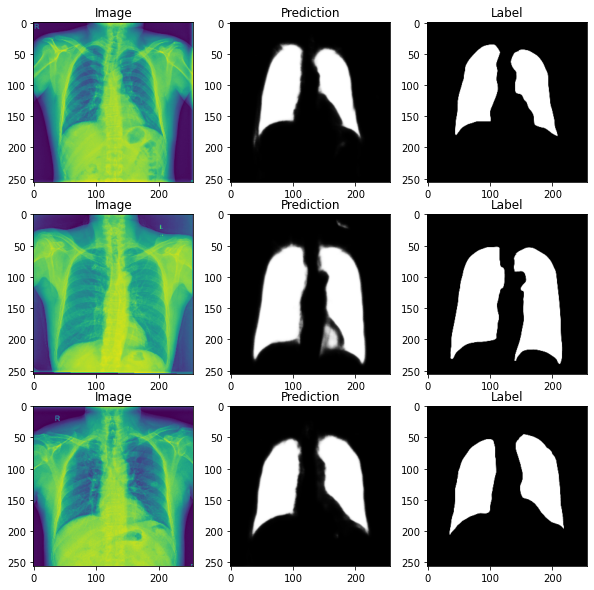

 75%|███████▌  | 75/100 [56:57<20:23, 48.95s/it]

[VALIDATION] Epoch : 74, Loss : 0.05778


 76%|███████▌  | 76/100 [57:37<18:30, 46.26s/it]

[TRAIN] Epoch : 75, Loss : 0.03586


 77%|███████▋  | 77/100 [58:14<16:40, 43.48s/it]

[TRAIN] Epoch : 76, Loss : 0.03315


 78%|███████▊  | 78/100 [58:47<14:45, 40.25s/it]

[TRAIN] Epoch : 77, Loss : 0.03242


 79%|███████▉  | 79/100 [59:21<13:24, 38.33s/it]

[TRAIN] Epoch : 78, Loss : 0.03429
[TRAIN] Epoch : 79, Loss : 0.03101


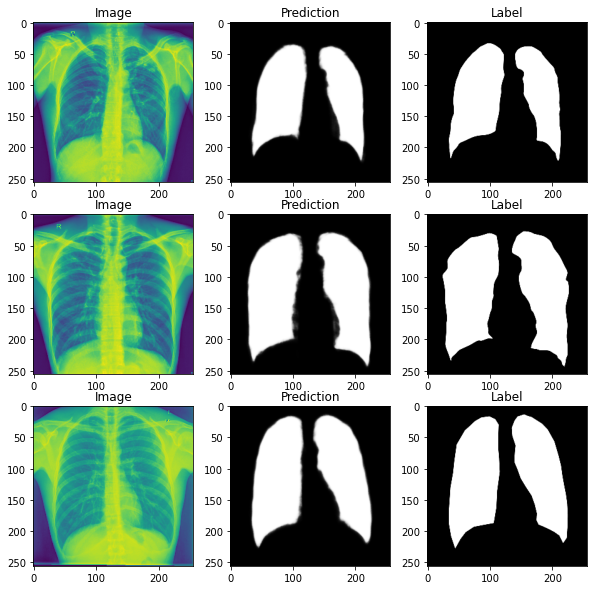

 80%|████████  | 80/100 [1:00:34<16:16, 48.81s/it]

[VALIDATION] Epoch : 79, Loss : 0.06388


 81%|████████  | 81/100 [1:01:09<14:06, 44.55s/it]

[TRAIN] Epoch : 80, Loss : 0.03016


 82%|████████▏ | 82/100 [1:01:46<12:43, 42.42s/it]

[TRAIN] Epoch : 81, Loss : 0.02963


 83%|████████▎ | 83/100 [1:02:15<10:51, 38.34s/it]

[TRAIN] Epoch : 82, Loss : 0.02897


 84%|████████▍ | 84/100 [1:03:01<10:48, 40.52s/it]

[TRAIN] Epoch : 83, Loss : 0.02803
[TRAIN] Epoch : 84, Loss : 0.02847


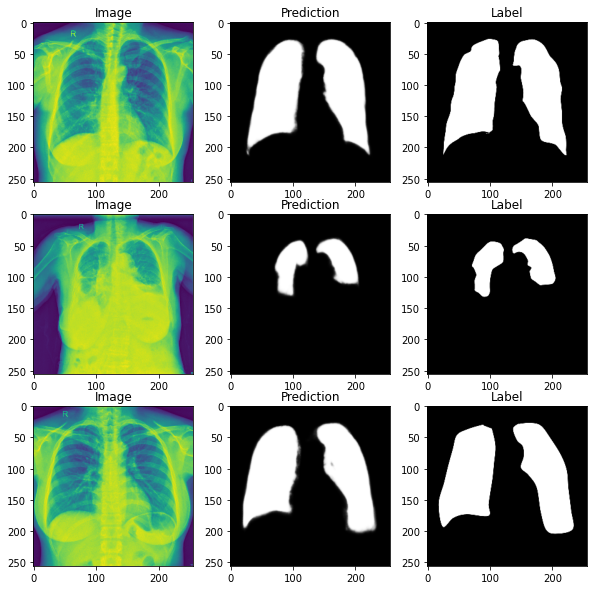

 85%|████████▌ | 85/100 [1:04:15<12:38, 50.59s/it]

[VALIDATION] Epoch : 84, Loss : 0.07125


 86%|████████▌ | 86/100 [1:04:48<10:34, 45.29s/it]

[TRAIN] Epoch : 85, Loss : 0.02934


 87%|████████▋ | 87/100 [1:05:24<09:15, 42.71s/it]

[TRAIN] Epoch : 86, Loss : 0.02760


 88%|████████▊ | 88/100 [1:05:59<08:03, 40.31s/it]

[TRAIN] Epoch : 87, Loss : 0.02904


 89%|████████▉ | 89/100 [1:06:37<07:15, 39.61s/it]

[TRAIN] Epoch : 88, Loss : 0.02727
[TRAIN] Epoch : 89, Loss : 0.02636


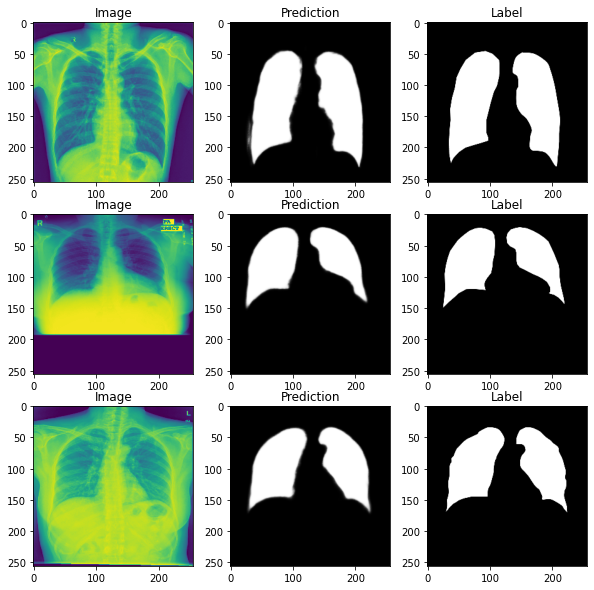

 90%|█████████ | 90/100 [1:07:49<08:13, 49.39s/it]

[VALIDATION] Epoch : 89, Loss : 0.07028


 91%|█████████ | 91/100 [1:08:32<07:06, 47.44s/it]

[TRAIN] Epoch : 90, Loss : 0.02599


 92%|█████████▏| 92/100 [1:09:06<05:47, 43.41s/it]

[TRAIN] Epoch : 91, Loss : 0.02598


 93%|█████████▎| 93/100 [1:09:41<04:46, 40.97s/it]

[TRAIN] Epoch : 92, Loss : 0.03580


 94%|█████████▍| 94/100 [1:10:17<03:56, 39.34s/it]

[TRAIN] Epoch : 93, Loss : 0.34113
[TRAIN] Epoch : 94, Loss : 0.32784


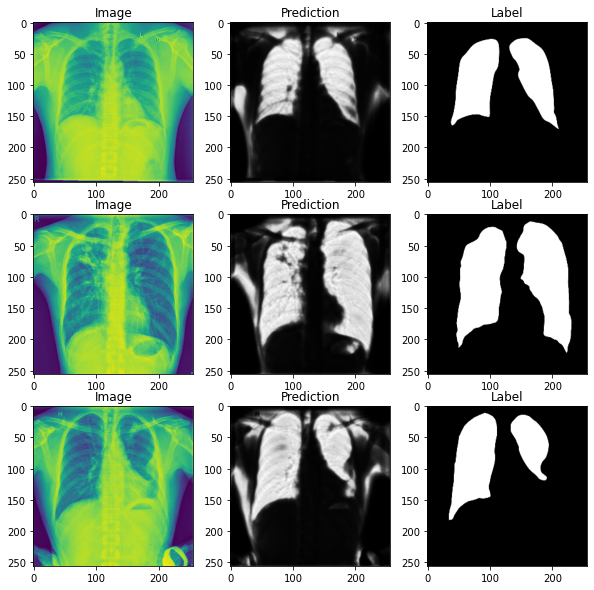

 95%|█████████▌| 95/100 [1:11:30<04:07, 49.44s/it]

[VALIDATION] Epoch : 94, Loss : 0.37288


 96%|█████████▌| 96/100 [1:12:06<03:01, 45.29s/it]

[TRAIN] Epoch : 95, Loss : 0.23944


 97%|█████████▋| 97/100 [1:12:39<02:05, 41.75s/it]

[TRAIN] Epoch : 96, Loss : 0.29024


 98%|█████████▊| 98/100 [1:13:16<01:20, 40.29s/it]

[TRAIN] Epoch : 97, Loss : 0.16822


 99%|█████████▉| 99/100 [1:13:52<00:39, 39.07s/it]

[TRAIN] Epoch : 98, Loss : 0.12748
[TRAIN] Epoch : 99, Loss : 0.11502


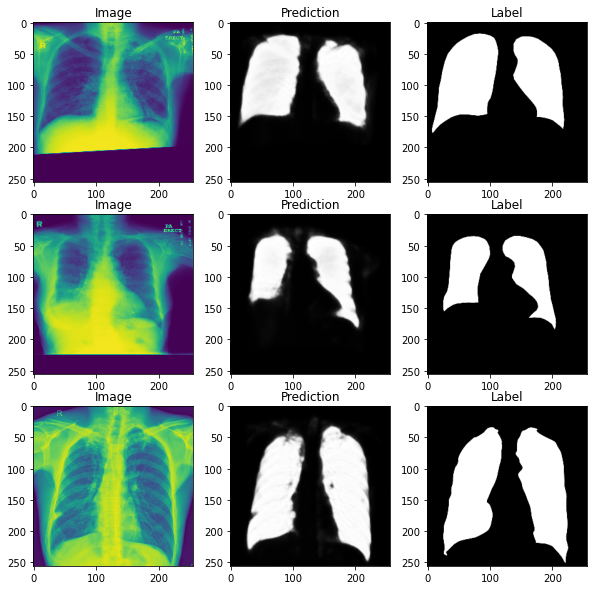

100%|██████████| 100/100 [1:15:10<00:00, 45.10s/it]

[VALIDATION] Epoch : 99, Loss : 0.08141


In [9]:
train_size = 100
use_augmentation = False
augmentation_type = "no"
augmentation_size = 0
augmentation_dir = ""
model_path = f"model_{augmentation_type}_aug_{augmentation_size}_train_{train_size}.pt"

# get datasets
train_set = dataset.get_train_data(images_dir,
                                   train_size = train_size,
                                   use_augmentation = use_augmentation,
                                   augmentation_type = augmentation_type,
                                   augmentation_size = augmentation_size,
                                   augmentation_dir = augmentation_dir)
val_set = dataset.get_val_data(images_dir)
test_set = dataset.get_test_data(images_dir)

# setup dataloaders
batch_size = 8
train_dataloader = DataLoader(train_set, batch_size = batch_size, shuffle = True)
val_dataloader = DataLoader(val_set, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_set, batch_size = 1, shuffle = True)

train(model, train_dataloader, val_dataloader, model_path)

### Test accuracy of all the models

In [ ]:
model_names = sorted([i for i in os.listdir('seg') if i.endswith('.pt')])
for model in model_names:
    test_accuracy = test(os.path.join('seg/', model), test_dataloader)
    print(model, test_accuracy)

### Results - Dice Scores



|Train Size| Without Augmentation | Baseline Augmentation| With Augmentation |
| :-: | :-: |:-: | :-: |
| 0   | -       | 0.794 | 0.826 |
| 20  | 0.863  | 0.907 | 0.922  |
| 50  | 0.904  | 0.938 | 0.931 |
| 100 | 0.935 | 0.940 | 0.948 |
| 200 | 0.946 | 0.948 | 0.950 |